https://github.com/Amir-Hofo

--------

# 00_Arguments

In [ ]:
system= "colab"
seed= False

wandb_enable= True
if wandb_enable:
  wandb_arg_name= input('Please input the WandB argument name:')

batch_size= 128
max_seq_length= 20

embed_size= 300
num_layers= 2
hidden_size= 500
dropout_embd= 0.5
dropout_rnn= 0.5


lr= 0.1
wd= 1e-4
momentum= 0.9
clip= 0.25

-----------

# 01_Library

## insatll

In [ ]:
try:
    import torchtext
except ImportError:
    ! pip install -q torchtext==0.17.0
    import torchtext

try:
    import torchvision
except:
    ! pip uninstall -q -y torchvision
    ! pip install -q torchvision==0.17.0
    import torchvision

! pip install -q torchmetrics tqdm wandb torcheval

In [ ]:
# !pip uninstall -q -y torch torchvision torchtext
# !pip install -q torch=2.2.2 torchtext==0.17.2 torchvision==0.17.2

## import

In [ ]:
import os
import urllib.request
import zipfile
from collections import Counter
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import wandb
import tqdm
import torchmetrics as tm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split

from torchvision import transforms
from torchvision.datasets import VisionDataset
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

try:
    from torcheval.metrics import BLEUScore
except:
    import torcheval
    from bleu import BLEUScore

In [ ]:
! python --version
for lib in [torch, torchtext, torchvision]:
  print(lib.__name__, '-->', lib.__version__)

Python 3.11.11
torch --> 2.2.0+cu121
torchtext --> 0.17.0+cpu
torchvision --> 0.17.0+cu121


-------

# 02_Utils

## system

In [ ]:
if system== "local":
    project_path= r"./"
    dataset_path= './dataset/'

elif system== "colab":
    root_path= '/content/'
    project_path= r"/content/drive/MyDrive/Catalist/2_image captioning/"
    dataset_path= os.path.join(project_path, r'dataset/')

else:
  raise ValueError("Invalid system")

## device

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
pin_memory= (device == 'cuda')
device

'cuda'

## drive mount

In [ ]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## number of params fn

In [ ]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## avragemeter

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## set seed

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

--------------

# 03_Data

## download dataset

In [ ]:
image_link= "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
caption_link= "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

files = {
    "Flickr8k_Dataset.zip": image_link,
    "Flickr8k_text.zip": caption_link
}

for filename, url in files.items():
  if not os.path.exists(os.path.join(dataset_path, filename)):
    urllib.request.urlretrieve(url, os.path.join(dataset_path, filename))
    print(f"{filename} has been downloaded.")
  else:
    print(f"{filename} already exists.")

Flickr8k_Dataset.zip already exists.
Flickr8k_text.zip already exists.


## unzip

In [ ]:
files= ["Flickr8k_Dataset.zip", "Flickr8k_text.zip"]
data_path= os.path.join(root_path, "dataset/")
os.makedirs(data_path, exist_ok= True)
for file in files:
    with zipfile.ZipFile(os.path.join(dataset_path, file), 'r') as zip_ref:
        zip_ref.extractall(data_path)
    print(f"{file} extraction is complete.")

Flickr8k_Dataset.zip extraction is complete.
Flickr8k_text.zip extraction is complete.


## custom dataset

### pytorch Flickr30k class

In [ ]:
# import glob
# import os
# from collections import defaultdict
# from html.parser import HTMLParser
# from pathlib import Path
# from typing import Any, Callable, Dict, List, Optional, Tuple, Union

# from .folder import default_loader
# from .vision import VisionDataset


# class Flickr30k(VisionDataset):
#     """`Flickr30k Entities <https://bryanplummer.com/Flickr30kEntities/>`_ Dataset.

#     Args:
#         root (str or ``pathlib.Path``): Root directory where images are downloaded to.
#         ann_file (string): Path to annotation file.
#         transform (callable, optional): A function/transform that takes in a PIL image or torch.Tensor, depends on the given loader,
#             and returns a transformed version. E.g, ``transforms.RandomCrop``
#         target_transform (callable, optional): A function/transform that takes in the
#             target and transforms it.
#         loader (callable, optional): A function to load an image given its path.
#             By default, it uses PIL as its image loader, but users could also pass in
#             ``torchvision.io.decode_image`` for decoding image data into tensors directly.
#     """

#     def __init__(
#         self,
#         root: str,
#         ann_file: str,
#         transform: Optional[Callable] = None,
#         target_transform: Optional[Callable] = None,
#         loader: Callable[[str], Any] = default_loader,
#     ) -> None:
#         super().__init__(root, transform=transform, target_transform=target_transform)
#         self.ann_file = os.path.expanduser(ann_file)

#         # Read annotations and store in a dict
#         self.annotations = defaultdict(list)
#         with open(self.ann_file) as fh:
#             for line in fh:
#                 img_id, caption = line.strip().split("\t")
#                 self.annotations[img_id[:-2]].append(caption)

#         self.ids = list(sorted(self.annotations.keys()))
#         self.loader = loader

#     def __getitem__(self, index: int) -> Tuple[Any, Any]:
#         """
#         Args:
#             index (int): Index

#         Returns:
#             tuple: Tuple (image, target). target is a list of captions for the image.
#         """
#         img_id = self.ids[index]

#         # Image
#         filename = os.path.join(self.root, img_id)
#         img = self.loader(filename)
#         if self.transform is not None:
#             img = self.transform(img)

#         # Captions
#         target = self.annotations[img_id]
#         if self.target_transform is not None:
#             target = self.target_transform(target)

#         return img, target

#     def __len__(self) -> int:
#         return len(self.ids)

### custom Flickr dataset

In [ ]:
class Flickr8k(VisionDataset):
    """
    Args:
        root (string): Root directory where images are downloaded to.
        ann_file (string): Path to annotation file.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self,
                 root: str,
                 ann_file: str,
                 split_file: str,
                 train: bool,
                 transform: Optional[Callable]= None,
                 target_transform: Optional[Callable]= None):
        super().__init__(root, transform= transform,
                         target_transform= target_transform)
        self.ann_file= os.path.expanduser(ann_file)
        self.train= train

        # Read {train/dev/test} files
        with open(split_file) as f:
            self.split_samples= f.read().strip().split("\n")

        # Read annotations and store in a dict
        self.ids, self.captions= [], []
        with open(self.ann_file) as fh:
            for line in fh:
                img_id, caption= line.strip().split("\t")
                if img_id[:-2] in self.split_samples:
                    self.ids.append(img_id[:-2])
                    self.captions.append(caption)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is a list of captions for the image.
        """
        img_id= self.ids[index]

        # Image
        filename= os.path.join(self.root, img_id)
        img_raw= Image.open(filename).convert("RGB")
        if self.transform is not None:
            img= self.transform(img_raw)

        # Captions
        caption= self.captions[index]
        if self.target_transform is not None:
            target= self.target_transform(caption)

        if self.train:
            return img, target
        else:
          return img, img_raw, caption

    def __len__(self) -> int:
        return len(self.ids)

### caption transform

In [ ]:
class CaptionTransform:

    def __init__(self, caption_file):
        captions= self._load_captions(caption_file)

        self.tokenizer= get_tokenizer('basic_english')
        self.vocab= build_vocab_from_iterator(map(self.tokenizer, captions),
                                              specials= ['<pad>', '<unk>', '<sos>', '<eos>'])
        self.vocab.set_default_index(self.vocab['<unk>'])
        torch.save(self.vocab, 'vocab.pt')

    def __call__(self, caption):
        indices= self.vocab(self.tokenizer(caption))
        indices= self.vocab(['<sos>']) + indices + self.vocab(['<eos>'])
        target= torch.LongTensor(indices)
        return target

    def __repr__(self):
        return f"""CaptionTransform([
          _load_captions(),
          toknizer('basic_english'),
          vocab(vocab_size={len(self.vocab)}) ])
          """

    def _load_captions(self, caption_file):
        captions= []
        with open(caption_file) as f:
            for line in f:
                _, caption= line.strip().split("\t")
                captions.append(caption)
        return captions

In [ ]:
caption_transform= CaptionTransform(os.path.join(data_path, 'Flickr8k.token.txt'))

## transform

In [ ]:
train_transform= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])

eval_transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])

## dataset

In [ ]:
split_file= lambda phase: f'{data_path}Flickr_8k.{phase}Images.txt'

train_set= Flickr8k(os.path.join(data_path, 'Flicker8k_Dataset'),
                    os.path.join(data_path, 'Flickr8k.token.txt'),
                    split_file('train'), True,
                    train_transform, caption_transform)

valid_set= Flickr8k(os.path.join(data_path, 'Flicker8k_Dataset'),
                    os.path.join(data_path, 'Flickr8k.token.txt'),
                    split_file('dev'), True,
                    eval_transform, caption_transform)

test_set= Flickr8k(os.path.join(data_path, 'Flicker8k_Dataset'),
                   os.path.join(data_path, 'Flickr8k.token.txt'),
                   split_file('test'), False,
                   eval_transform, caption_transform)

len(train_set), len(valid_set), len(test_set)

(30000, 5000, 5000)

## dataloader

In [ ]:
def collate_fn(batch):
  if len(batch[0]) == 2:
      x_batch, y_batch= zip(*batch)
      x_batch= torch.stack(x_batch)
      y_batch= pad_sequence(y_batch, batch_first= True,
                            padding_value= caption_transform.vocab['<pad>'])
      return x_batch, y_batch
  else:
    x_batch, x_raw, captions= zip(*batch)
    x_batch= torch.stack(x_batch)
    return x_batch, x_raw, captions

In [ ]:
train_loader= DataLoader(train_set, batch_size= batch_size,
                         shuffle= True, collate_fn= collate_fn,
                         pin_memory= pin_memory)
valid_loader= DataLoader(valid_set, batch_size= batch_size*2,
                         collate_fn= collate_fn, pin_memory= pin_memory)
test_loader= DataLoader(test_set, batch_size= batch_size*2,
                        collate_fn= collate_fn, pin_memory= pin_memory)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("Test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 128 , num of batch: 235
valid batch size: 256 , num of batch: 20
Test batch size: 256 , num of batch: 20


-----------

# 04_Model

## encoder

In [ ]:
class EncoderCNN(nn.Module):

  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    self.resnet= resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)
    self.resnet.requires_grad_(False)
    feature_size= self.resnet.fc.in_features

    self.resnet.fc= nn.Identity()
    self.linear= nn.Linear(feature_size, embed_size)
    self.bn= nn.BatchNorm1d(embed_size)

  def forward(self, images):
    self.resnet.eval()
    with torch.no_grad():
      features= self.resnet(images)
    features= self.bn(self.linear(features))
    return features

## decoder

In [ ]:
class DecoderRNN(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,
               dropout_embd, dropout_rnn, max_seq_length= 20):
    super(DecoderRNN, self).__init__()
    self.embedding= nn.Embedding(vocab_size, embed_size,
                                 padding_idx= caption_transform.vocab['<pad>'])
    self.dropout_embd= nn.Dropout(dropout_embd)

    self.lstm= nn.LSTM(embed_size, hidden_size, num_layers,
                       dropout= dropout_rnn, batch_first= True)

    self.linear= nn.Linear(hidden_size, vocab_size)
    self.max_seq_length= max_seq_length
    self.init_weights()

  def init_weights(self):
      self.embedding.weight.data.uniform_(-0.1, 0.1)
      self.linear.bias.data.fill_(0)
      self.linear.weight.data.uniform_(-0.1, 0.1)

  def forward(self, features, captions):
    embeddings= self.dropout_embd(self.embedding(captions[:, :-1]))
    inputs= torch.cat((features.unsqueeze(1), embeddings), dim= 1)
    outputs, _= self.lstm(inputs)
    outputs= self.linear(outputs)
    return outputs

  def generate(self, features, captions):
    if len(captions) > 0:
        embeddings= self.dropout_embd(self.embedding(captions))
        inputs= torch.cat((features.unsqueeze(1), embeddings), dim= 1)
    else:
        inputs= features.unsqueeze(1)

    outputs, _= self.lstm(inputs)
    outputs= self.linear(outputs)
    return outputs

## custom model

In [ ]:
class ImageCaptioning(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,
               dropout_embd, dropout_rnn, max_seq_length= 20):
    super(ImageCaptioning, self).__init__()
    self.encoder= EncoderCNN(embed_size)
    self.decoder= DecoderRNN(embed_size, hidden_size, vocab_size, num_layers,
                             dropout_embd, dropout_rnn, max_seq_length)

  def forward(self, images, captions):
    features= self.encoder(images)
    outputs= self.decoder(features, captions)
    return outputs

  def generate(self, images, captions):
    features= self.encoder(images)
    outputs= self.decoder.generate(features, captions)
    return outputs

## configuration

In [ ]:
loss_fn= nn.CrossEntropyLoss(ignore_index= caption_transform.vocab['<pad>'])

In [ ]:
if wandb_enable:
  key_file= os.path.join(project_path, 'key.txt')
  if os.path.exists(key_file):
      with open(key_file) as f:
          key= f.readline().strip()
      wandb.login(key= key)
  else:
      print("Key file does not exist. ",
          "Please create the key file with your wandb API key.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amirhossien922 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


----------------

# 05_Train one epoch

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric= None, epoch= None):
  model.train()
  loss_train= AverageMeter()
  if metric: metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs, targets= inputs.to(device), targets.to(device)
      outputs= model(inputs, targets)
      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm= clip)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n= len(targets))
      if metric:
        metric.update(outputs, targets)
        metric_train_val= metric.compute().item()
      else:
        metric_train_val= None

      tepoch.set_postfix(loss= loss_train.avg, metric= metric_train_val)

    return model, loss_train.avg, metric_train_val

In [ ]:
def evaluate(model, test_loader, loss_fn, metric= None):
  model.eval()
  loss_eval= AverageMeter()
  if metric: metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs, targets= inputs.to(device), targets.to(device)
      outputs= model(inputs, targets)
      loss= loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n= len(targets))
      if metric: metric(outputs, targets)

  return loss_eval.avg, metric.compute().item() if metric else None

---------

# 06_Experiments before the main training

## base loss

In [ ]:
model= ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab),
                       num_layers, dropout_embd, dropout_rnn, max_seq_length).to(device)

loss_base, _= evaluate(model, valid_loader, loss_fn)
print(f'{loss_base:.2f}')

9.10


## overfit on subset of data

In [ ]:
num_epochs= 20
mini_train_size= 1000

optimizer= torch.optim.SGD(model.parameters(), lr= lr, momentum= momentum)
_, mini_train_dataset= random_split(train_set, (len(train_set)- mini_train_size,
                                                mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, 20, collate_fn= collate_fn)

for epoch in range(num_epochs):
  model, _, _= train_one_epoch(model, mini_train_loader, loss_fn, optimizer, None, epoch)

del mini_train_dataset, mini_train_loader

Epoch 19: 100%|██████████| 50/50 [00:09<00:00,  5.07batch/s, loss=3.11, metric=None]


## rough grid

In [ ]:
num_epochs= 1
loss_grid= loss_base

for lr in [0.9, 1.5, 0.125]:
  print(f'LR={lr}')

  model= ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab),
                         num_layers, dropout_embd, dropout_rnn, max_seq_length).to(device)
  model= torch.load(f'{project_path}model.pt', map_location= device)
  optimizer= optim.SGD(model.parameters(), lr= lr,
                       weight_decay= wd, momentum= momentum)

  for epoch in range(num_epochs):
    model, loss, _= train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)
  if loss< loss_grid:
    best_lr= lr
    loss_grid= loss
    print(f'best loss is: {loss_grid} with lr: {best_lr}')
  print()

LR=0.9


Epoch 1: 100%|██████████| 235/235 [05:09<00:00,  1.32s/batch, loss=2.38, metric=None]


best loss is: 2.383197246805827 with lr: 0.9

LR=1.5


Epoch 1: 100%|██████████| 235/235 [04:58<00:00,  1.27s/batch, loss=2.51, metric=None]



LR=0.125


Epoch 1: 100%|██████████| 235/235 [04:54<00:00,  1.25s/batch, loss=2.22, metric=None]

best loss is: 2.215916396077474 with lr: 0.125



## grid search

In [45]:
num_epochs= 2

for lr in [best_lr, 0.5*best_lr, 1.5*best_lr]:
  for wd in [1e-4]: #, 0
    print(f'LR={lr}, WD={wd}')

    model= ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab),
                          num_layers, dropout_embd, dropout_rnn, max_seq_length).to(device)
    model= torch.load(f'{project_path}model.pt', map_location= device)
    optimizer = optim.SGD(model.parameters(), lr= lr,
                          weight_decay= wd, momentum= momentum)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)
    loss_valid, _= evaluate(model, valid_loader, loss_fn, None)
    print(f'Valid: Loss= {loss_valid:.4}')
    print()

LR=0.01, WD=0.0001


Epoch 2: 100%|██████████| 235/235 [04:59<00:00,  1.27s/batch, loss=2.22, metric=None]


Valid: Loss= 2.667



------------

# 07_Training

In [ ]:
if seed:
  set_seed(seed)

loss_train_hist, loss_valid_hist= [], []
metric_train_hist, metric_valid_hist= [], []
best_loss_valid= torch.inf
epoch_counter= 0

model= ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                       dropout_embd, dropout_rnn, max_seq_length).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s] 


In [46]:
lr, wd= 0.0625, 1e-4 # 12-> 0.9 + 3-> 0.0625
metric= None
model= torch.load(f'{project_path}model.pt', map_location= device)
optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= momentum)

In [ ]:
if wandb_enable:
  wandb.init(
      project= 'Image-Captioning',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'wd': wd,
          'batch_size': batch_size,
          'seq_len': max_seq_length,
          'hidden_dim': hidden_size,
          'embedding_dim': embed_size,
          'num_layers': num_layers,
          'dropout_embed': dropout_embd,
          'dropout_lstm': dropout_rnn,
          'clip': clip,
      }
  )

In [48]:
if seed:
  set_seed(seed)

num_epochs= 3
for epoch in range(1, num_epochs+1):
  model, loss_train, metric_train= train_one_epoch(model, train_loader,
                                                   loss_fn, optimizer,
                                                   metric, epoch)

  loss_valid, metric_valid= evaluate(model, valid_loader,
                                            loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'{project_path}model.pt')
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}')#, Metric= {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"loss_train": loss_train, "loss_valid": loss_valid})
    #"metric_train": metric_train, "metric_valid": metric_valid

  epoch_counter += 1

Epoch 1: 100%|██████████| 235/235 [05:03<00:00,  1.29s/batch, loss=2.14, metric=None]


Valid: Loss= 2.657



Epoch 2:  21%|██▏       | 50/235 [01:04<03:59,  1.29s/batch, loss=2.11, metric=None]


KeyboardInterrupt: 

In [49]:
wandb.finish()
torch.save(test_loader, f'{project_path}test_loader.pt')

loss_train,█▆▅▅▄▄▃▃▃▃▃▂▁▁▁
loss_valid,█▆▅▄▃▃▃▃▂▂▂▁▁▁▁
loss_train,2.13743
loss_valid,2.65681


----------

# 08_Learning curve

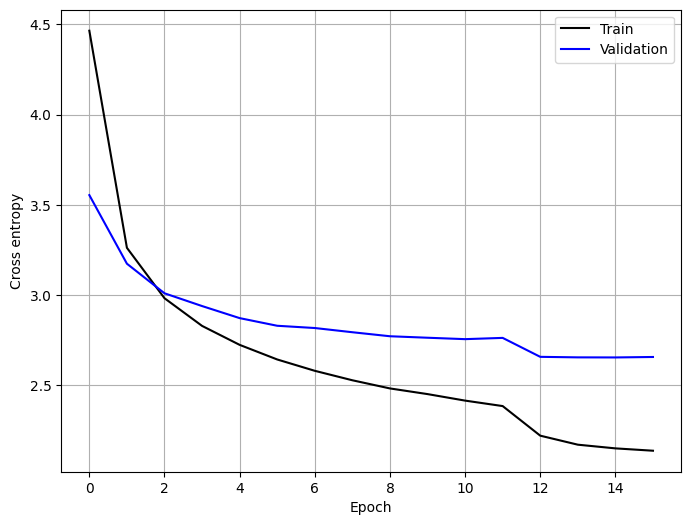

In [50]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.grid(True)
plt.legend()

--------

# 09_Caption Generator

In [51]:
def generate(image, model, vocab, max_seq_len, device):
  image= image.to(device)
  src, indices= [], []
  caption= ''
  itos= vocab.get_itos()

  for i in range(max_seq_len):
    with torch.no_grad():
      predictions= model.generate(image, src)

    idx= predictions[:, -1, :].argmax(1)
    token= itos[idx]

    caption += token + ' '
    if idx == vocab['<eos>']:
      break

    indices.append(idx)
    src= torch.LongTensor([indices]).to(device)

  return caption.replace('<sos> ', '').replace(' <eos>', '').capitalize()

In [52]:
model= torch.load(f'{project_path}model.pt', map_location= device)
test_set_generate= Flickr8k(os.path.join(data_path, 'Flicker8k_Dataset'),
                            os.path.join(data_path, 'Flickr8k.token.txt'),
                            split_file('test'),
                            False, eval_transform, caption_transform)

Target:  A BMX rider in a red and black outfit is jumping on his motorcycle .
Model: A person on a bike is jumping over a dirt hill . 


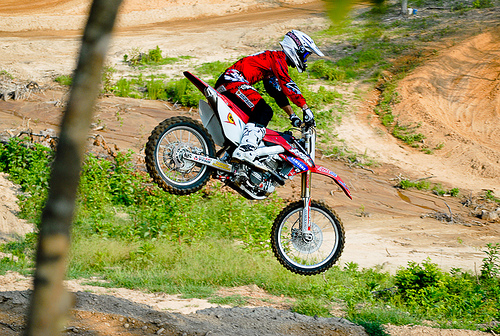

In [69]:
idx= torch.randint(0, len(test_set_generate), (1,)).item()
image, image_raw, target= test_set_generate[idx]

caption= generate(image.unsqueeze(0), model,
                  caption_transform.vocab, 20, device)

print('Target: ', target)
print('Model:', caption)
image_raw

----------

# 10_Test

In [54]:
def calculate_bleu(model, dataloader, tokenizer, vocab,
                   n_gram, device, max_seq_len=20):
    bleu= BLEUScore(n_gram= n_gram)
    for images, _, captions in dataloader:
        images= images.to(device)
        generated_caption= generate(images[[0], ...], model,
                                    vocab, max_seq_len, device)

        candidates, references= [generated_caption], [captions]
        bleu.update(candidates, references)

    return bleu.compute()

In [55]:
test_set_generate= Flickr8k(os.path.join(data_path, 'Flicker8k_Dataset'),
                            os.path.join(data_path, 'Flickr8k.token.txt'),
                            split_file('test'), False, eval_transform, caption_transform)
test_loader = DataLoader(test_set_generate, batch_size= 5, collate_fn= collate_fn)

In [56]:
bleu_1= calculate_bleu(model, test_loader, caption_transform.tokenizer,
                       caption_transform.vocab, 1, device)
bleu_2= calculate_bleu(model, test_loader, caption_transform.tokenizer,
                       caption_transform.vocab, 2, device)
bleu_3= calculate_bleu(model, test_loader, caption_transform.tokenizer,
                       caption_transform.vocab, 3, device)
bleu_4= calculate_bleu(model, test_loader, caption_transform.tokenizer,
                       caption_transform.vocab, 4, device)

print(f'BLEU 1: {bleu_1}\nBLEU 2: {bleu_2}\nBLEU 3: {bleu_3}\nBLEU 4: {bleu_4}')

BLEU 1: 0.6383840124041692
BLEU 2: 0.4285446137673662
BLEU 3: 0.2881637782213683
BLEU 4: 0.19336745159653607
